# Описание проекта 

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки. 

**Цель:** Приоритизировать гипотезы, провести A/B тест и принять решение по результатам тестирования.

**Ход проекта:**
- Приоритизация гипотез. Применение фреймворков ICE и RICE. Выявление различий между двумя методами
- Первичный анализ результатов A/B теста. 
- Анализ результатов теста с учетом аномальных значений. Сравнение результатов для "сырых" и "очищенных" данных.
- Принятие решений по результатам теста - остановка теста с победой группы/отсутствием разницы или же продолжение теста.

**Описание данных:**

Файл `hypothesis.csv` : 

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл `orders.csv` : 

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `visitors.csv` : 

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Приоритизация гипотез

### Подготовительный этап

Перед тем как начать работу, необходимо произвести подготовительные действия. Начнем с импорта необходимых библиотек:

In [143]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats

Теперь сохраним данные из файлов в переменных:

In [144]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

Проверим что данные в фреймах сохранены верно:

In [145]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [146]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [147]:
pd.options.display.max_colwidth = 130
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [148]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [149]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [150]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В таблицах `visitors` и `orders` необходимо столбец `date` привести к типу `datetime`:

In [151]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Теперь перейдем к дубликатам. Для начала проверим их количество в таблицах:

In [115]:
print('Количество дубликатов в таблице гипотез:', hypothesis['Hypothesis'].duplicated().sum()) #дубликаты гипотез проверяем по названию
print('Количество дубликатов в таблице заказов:', orders['transactionId'].duplicated().sum()) #дубликаты заказов можно проверить по их Id
print('Количество дубликатов в таблице пользователей:', visitors.duplicated().sum()) #в таблице данных теста дубликаты могут быть только полными

Количество дубликатов в таблице гипотез: 0
Количество дубликатов в таблице заказов: 0
Количество дубликатов в таблице пользователей: 0


Данные в порядке, можно переходить к приоритизации гипотез.

### Приоритизация с помощью фреймворка ICE

В файле `hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`. Проведем приоритизацию гипотез с помощью фреймворка `ICE`. Для этого создадим новый столбец `ICE` в таблице `hypothesis` и по нему же отсортируем таблицу:

In [116]:
hypothesis['ICE'] = round((hypothesis['Impact'] * hypothesis['Confidence'])/hypothesis['Efforts'],2)

hypothesis[['Hypothesis','ICE']].sort_values(by='ICE',ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Видно что 4 наиболее перспективных гипотезы это:
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

### Приоритизация с помощью фреймворка RICE

Теперь произведем расчеты для фреймворка `RICE` : 

In [117]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'])/hypothesis['Efforts']

hypothesis[['Hypothesis','RICE']].sort_values(by='RICE',ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Теперь ТОП-4 гипотез состоит из номеров 1, 3, 7, 8
Из необычного - в топ вырвалась гипотеза 3, а гипотеза 9 заняла лишь 5 место.
Посмотрим на полные названия гипотез:

In [118]:
hypothesis.loc[2,'Hypothesis']

'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа'

In [119]:
hypothesis.loc[8,'Hypothesis']

'Запустить акцию, дающую скидку на товар в день рождения'

Теперь все встает на свои места. Гипотеза 3 охватывает всех посетителей интернет магазина, показатель `Reach` достаточно высокий. А вот гипотеза 9 охватывает только тех пользователей, у которых будет день рождения в ближайшее время, за счет этого показатель `Reach` достаточно небольшой.

**Вывод:** Самыми перспективными гипотезами являются 8, 3, 1 и 7. Неплохим вариантом могла стать гипотеза номер 9, но ее охват пользователей слишком мал.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊<a class="tocSkip"> </h2>
    
Приоритизация гипотез проведена успешно! Молодец, что выводишь таблицу дважды, каждый раз с сортировкой по одному из фреймоврков, так различия в их работе будут максимально наглядными. Согласна с твоими выводами по поводу их различия. Будет здорово добавить в начало небольшое описание фремворков, в выводе вместе с номером, стоит указать полное название гипотез. 
</div>   

## Анализ A/B теста

### Анализ кумулятивных метрик

**1. Постройте график кумулятивной выручки по группам**

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм `cumulativeData` со столбцами: 

- `date` — дата;
- `group` — группа A/B-теста (A или B);
- `orders` — кумулятивное количество заказов на указанную дату в указанной группе;
- `buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [120]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])]
                                     .agg({'date' : 'max',
                                           'group' : 'max', 
                                           'transactionId' : 'nunique',
                                           'visitorId' : 'nunique', 
                                           'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])].
                                       agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Построим графики кумулятивной выручки по группам:

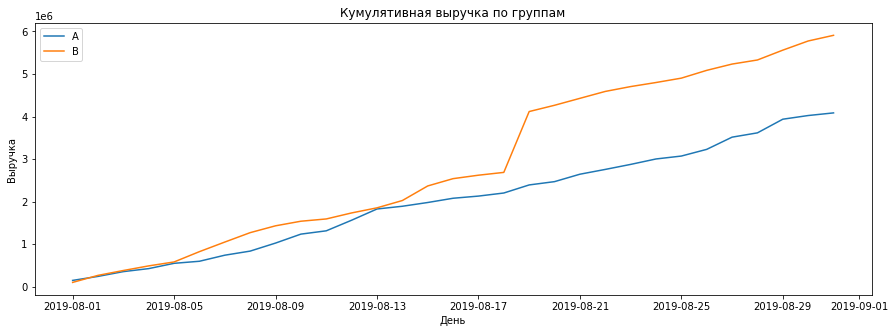

In [121]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize = (15,5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по группам')
plt.xlabel('День')
plt.ylabel('Выручка')
plt.legend()
plt.show()

Выручка равномерно увеличивается в течение всего теста в группе А, что достаточно хороший показатель. А вот в группе В есть один резкий скачок. Возможных причины две. Первая - резко возросло количество заказов. Вторая - в выборке появились очень дорогие заказы, аномальные значения. 


**2. Постройте график кумулятивного среднего чека по группам**

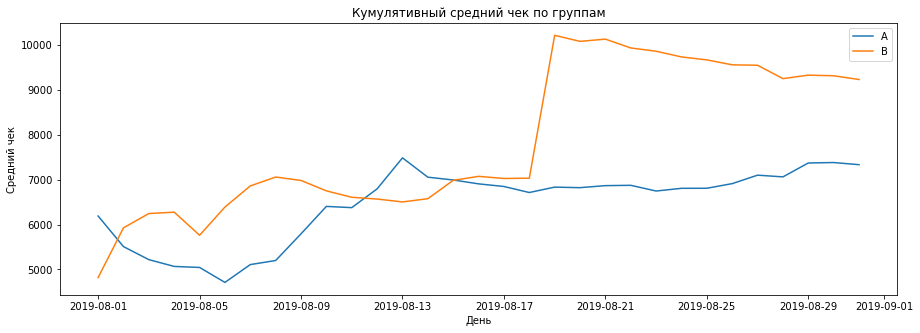

In [122]:
plt.figure(figsize = (15,5))
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('День')
plt.ylabel('Средний чек')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.show()

Средничк чек групп становится равномерным ближе к концу тестирования, однако у группы В снова есть резкий скачок в том же периоде как и у графика выручки. Теперь с уверенностью можно сказать что заказы с аномально большой суммой присутствуют в выборке В. Так как если бы был большой приток заказов со средней суммой, значение среднего чека не выросло бы так сильно. Необходим дальнейший анализ.

**3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A**

Добавим горизонтальную ось у=0 на график: 

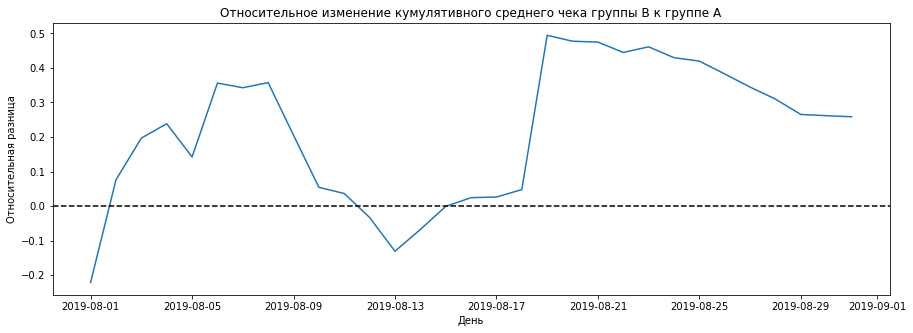

In [123]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize = (15,5))
plt.xlabel('День')
plt.ylabel('Относительная разница')
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Наличие выбросов снова подтверждается - есть несколько резких скачков разницы в выборках. При этом можно отметить что разница не осталась стабильной - она продолжает уменьшаться. Возможно произошло влияние выброса в выборке В а теперь оно постепенно "уравновешивается" объемом данных.

**4. Постройте график кумулятивного среднего количества заказов на посетителя по группам**

По сути необходимо посчитать кумулятивную конверсию в группах. Для этого можно столбец `orders` разделить на столбец `visitors` в таблице `cumulativeData`:

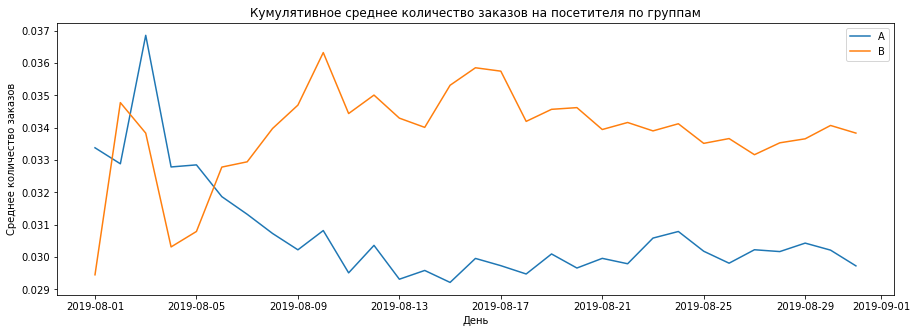

In [124]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(15,5))
plt.xlabel('День')
plt.ylabel('Среднее количество заказов')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend();

В начале теста группы колебались, но потом вышли на примерно одинаковое среднее значение, при том у группы В среднее количество заказов на человека значительно выше.

**5. Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**

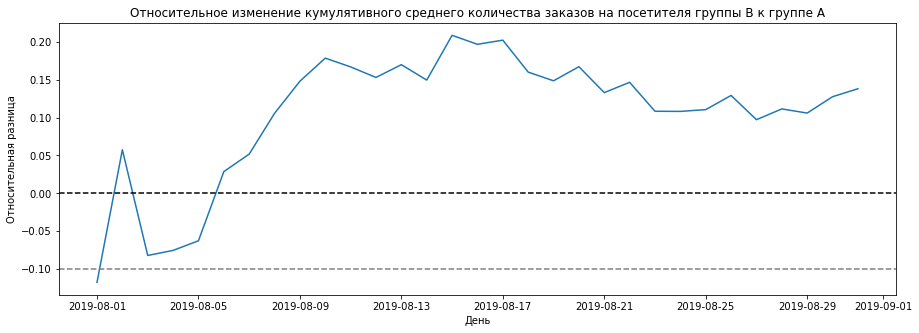

In [125]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize = (15,5))
plt.xlabel('День')
plt.ylabel('Относительная разница')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы В к группе А')
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--');

Конверсия группы В сначала колебалась, но потом вырвалась сильно вперед относительно группы А и теперь держится постепенно уменьшается.

### Анализ аномальных значений 

**6. Постройте точечный график количества заказов по пользователям**

Для начала подсчитаем количество заказов по пользователям:

In [126]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Заметим что есть пользователи которые совершили 8, 9 и даже 11 заказов что достаточно много. Нам необходимо построить точечную диаграмму распределения количества заказов на пользователя:

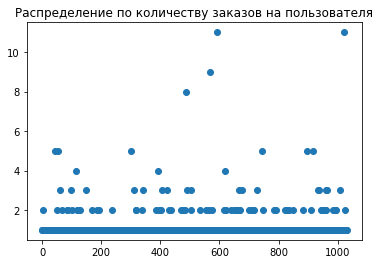

In [127]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.title('Распределение по количеству заказов на пользователя')

plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

Как видим - большинство пользователей совершают от 1 до 3 заказов. Однако их точная доля не ясна, необходим дальнейший анализ.

**7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей**

Для этого воспользуемся функцией `percentile`:

In [128]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. И 10% пользователей заказывали более одного раза. Как оказалось, можно даже отсечь пользователей с 3 заказами. 

Так как фильтрация идет по двум параметрам, то воспользуемся ограничением на 99 перцентиль и отбросим пользователей у которых более 4 заказов. 

**8. Построим точечный график стоимостей заказов**

Произведем действия аналогичные 7 пункту:

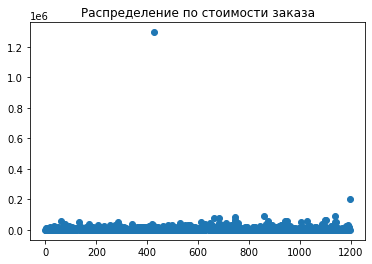

In [129]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.title('Распределение по стоимости заказа')
plt.scatter(x_values, orders['revenue']);

На графике можно заметить, что есть одно аномально большое значение, остальные заказы находятся примерно на одном уровне. Скорее всего этот аномальный заказ попал в выборку В чем и исказил результаты анализа. 

**9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов**

In [130]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


Таким образом не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей. Тогда примем границу для аномальных заказов в 58233.2 рубля.

### Расчет с разделением на "сырые" и "очищенные" данные

**10. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным**

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.
Начнём с подготовки данных. Создадим таблицу `data_row` содержащую сырые данные по заказам со следующими названиями столбцов:

- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

In [131]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data_row = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data_row.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами `['userId', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [132]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [133]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data_row['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                               name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data_row['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                               name='orders')],axis=0)

#применим критерий: 

print("Значение p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительная разница между группы В относительно группы А: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Значение p-value: 0.017
Относительная разница между группы В относительно группы А: 0.138


Первое полученное значение - `p-value`. Оно оказалось меньше чем 0.05, значит нулевую гипотезу отвергаем, между группами есть статистически значимое различие между средним количеством заказов на посетителя. При этом относительный выигрыш группы В равен 14.8% - второе выведенное число.

**11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным**

Произведем аналогичные действия. Нулевая гипотеза - различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [134]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                                   orders[orders['group']=='B']['revenue'])[1]))

print('Относительная разница: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()
                                              /orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.729
Относительная разница: 0.259


p-value значительно больше 0.05. Значит нет причин отвергать нулевую гипотезу, между группами нет статистически значимого различия. При этом относительный выигрыш среднего чека в группе В равен 25.9% что достаточно много 

**12. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным**

Для начала уберем заказы и пользователей с аномальными значениями: 

In [135]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], [90, 95, 99])[2]]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], [90, 95, 99])[2]]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [90, 95, 99])[2]]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64
15


Всего 15 аномальных пользователей, их нужно исключить. Подоготовим выборки "очищенных" данных и применим статистический критерий Манна-Уитни к полученным выборкам:

In [139]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_row['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_row['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительная разница: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.014
Относительная разница: 0.153


Полученные значения практически не отличаются от результатов в "сырых" выборках - значение `p-value` меньше 0.05, а значит нулевую гипотезу отвергаем, между данными есть статистически значимые различия (относительный выигрыш группы В вырос до 15.3%)

**13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным**

In [142]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительная разница: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.851
Относительная разница: -0.006


Если сравнивать с сырыми данными, то нулевая гипотеза все еще не отвергается, однако сильно изменилась относительная разница в среднем чеке - раньше группа В выигрывала почти на 26%, а теперь проигрывает на 0.6%. Произошло это за счет исключения того самого аномально большого заказа о котором упоминалось выше. Теперь не возникает вопросов почему между группами нет статистически значимой разницы в среднем чеке, однако 

## Итоговые выводы

Был проведен анализ А/В тестирования в итоге которого выяснились следующие факты:
- Есть статистически значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A, однако есть тенденция к уменьшению разницы между группами.
- График различия среднего чека говорит о том, что результаты группы B стали выше чем у группы А из за аномально большого заказа, однако теперь разница идет на спад.

Исходя из этого было принято остановить тест и зафиксировать победу группы В, так как присутствует статистически значимое различие по среднему количеству заказов, после фильтрации данных относительная разница составила 17.2%.